# NGFC Modelling with IDEAS - pse
This is a modelling example of a NGFC system using idaes-pse framework.
[Refer python modules from https://idaes-pse.readthedocs.io/en/stable/_modules/index.html]

In [1]:
from pyomo.environ import ConcreteModel, Constraint, Objective, SolverFactory, TransformationFactory, Constraint, Var
from pyomo.network import Arc

In [2]:
from idaes.core import FlowsheetBlock
from idaes.generic_models.unit_models import Mixer, HeatExchanger, Separator, GibbsReactor, Heater
from idaes.generic_models.unit_models.separator import SplittingType
from idaes.generic_models.unit_models.heat_exchanger import delta_temperature_amtd_callback
from idaes.core.util.model_statistics import degrees_of_freedom as dof
import idaes.generic_models.properties.activity_coeff_models.methane_combustion_ideal as thermo_props

### Building Base Flowsheet.

In [3]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
m.fs.thermo_params = thermo_props.MethaneParameterBlock()

In [4]:
# Fuel ultilization (Uf): mole reductant consumed in FC per mole of reductant total
Uf = 0.8
# Air ultilization (Ua): mole of air consumed in FC per mole of air feed
Ua = 0.2
# Methane to steam ratio (MS): mole methane per mole water
MS = 2
# Electrical conversion efficiency (EE): 
EE = 0.9
#Methane LHV: (https://www.engineeringtoolbox.com/fuels-higher-calorific-values-d_169.html)
LHV = 50000*16.04 # (J/g * g/mol = J/mol) 
# Heat of water vaporization @ 25 C: (https://www.engineeringtoolbox.com/water-properties-d_1573.html)
enthalpy_vap = 43988 # (J/mol)
# Feed:
# Reaction: 
# Reforming: CH4 + H2O -> CO + 3H2
# Water gas shift: CO + H2O -> CO2 + H2
# Methane combustion: CH4 + 2O2 -> CO2 + 2H2O
# Hydrogen combustion: H2 + 1/2O2 -> H2O
# Carbon monoxide combustion: CO + 1/2O2 -> CO2

n_CH4f = 10
print("mole of methane feed: "+str(n_CH4f)+" mole/s")
n_H2Of = n_CH4f*MS
print("mole of steam feed: "+str(n_H2Of)+" mole/s")
n_O2f = n_CH4f*Uf*2/Ua
n_N2f = n_O2f*0.79/0.21
print("mole of air feed: "+str(n_N2f+n_O2f)+" mole/s")

n_H2ex = 2
n_COex = n_CH4f*(1-Uf)*4-n_H2ex
n_CO2ex = n_CH4f-n_COex
n_H2Oex = n_H2Of+2*n_CH4f-n_H2ex
y_H2ex = n_H2ex/(n_H2ex + n_COex + n_CO2ex + n_H2Oex)
y_COex = n_COex/(n_H2ex + n_COex + n_CO2ex + n_H2Oex)
y_CO2ex = n_CO2ex/(n_H2ex + n_COex + n_CO2ex + n_H2Oex)
y_H2Oex = n_H2Oex/(n_H2ex + n_COex + n_CO2ex + n_H2Oex)

print("Anode exhaust: ")
print("y_H2ex: "+str(y_H2ex))
print("y_COex: "+str(y_COex))
print("y_CO2ex: "+str(y_CO2ex))
print("y_H2Oex: "+str(y_H2Oex))
print("Total mole/s: "+str(n_H2ex + n_COex + n_CO2ex + n_H2Oex))

n_N2ex = n_N2f
n_O2ex = n_O2f - n_CH4f*Uf*2
y_O2ex = n_O2ex/(n_O2ex+n_N2ex)
y_N2ex = n_N2ex/(n_O2ex+n_N2ex)
print("Cathode exhaust: ")
print("y_O2ex: "+str(y_O2ex))
print("y_N2ex: "+str(y_N2ex))
print("Total mole/s: "+str(n_O2ex+n_N2ex))

mole of methane feed: 10 mole/s
mole of steam feed: 20 mole/s
mole of air feed: 380.95238095238096 mole/s
Anode exhaust: 
y_H2ex: 0.04
y_COex: 0.11999999999999997
y_CO2ex: 0.08000000000000003
y_H2Oex: 0.76
Total mole/s: 50.0
Cathode exhaust: 
y_O2ex: 0.1753653444676409
y_N2ex: 0.824634655532359
Total mole/s: 364.95238095238096


In [5]:
# Temperature input
# Need to know: 
# _temperature of air coming in to fuel cell (FC) (T_FC_air_in)
# _temperature of fuel coming into (FC)/temperature of reformer (T_FC_fuel_in)
# _temperature of exhaust coming out of FC (T_FC_ex_out)
T_FC_air_in = 700 + 273.15
T_FC_fuel_in = 500 + 273.15
T_FC_ex_out = 800 + 273.15

### Blue coded solid material streams can be solved from given specifications

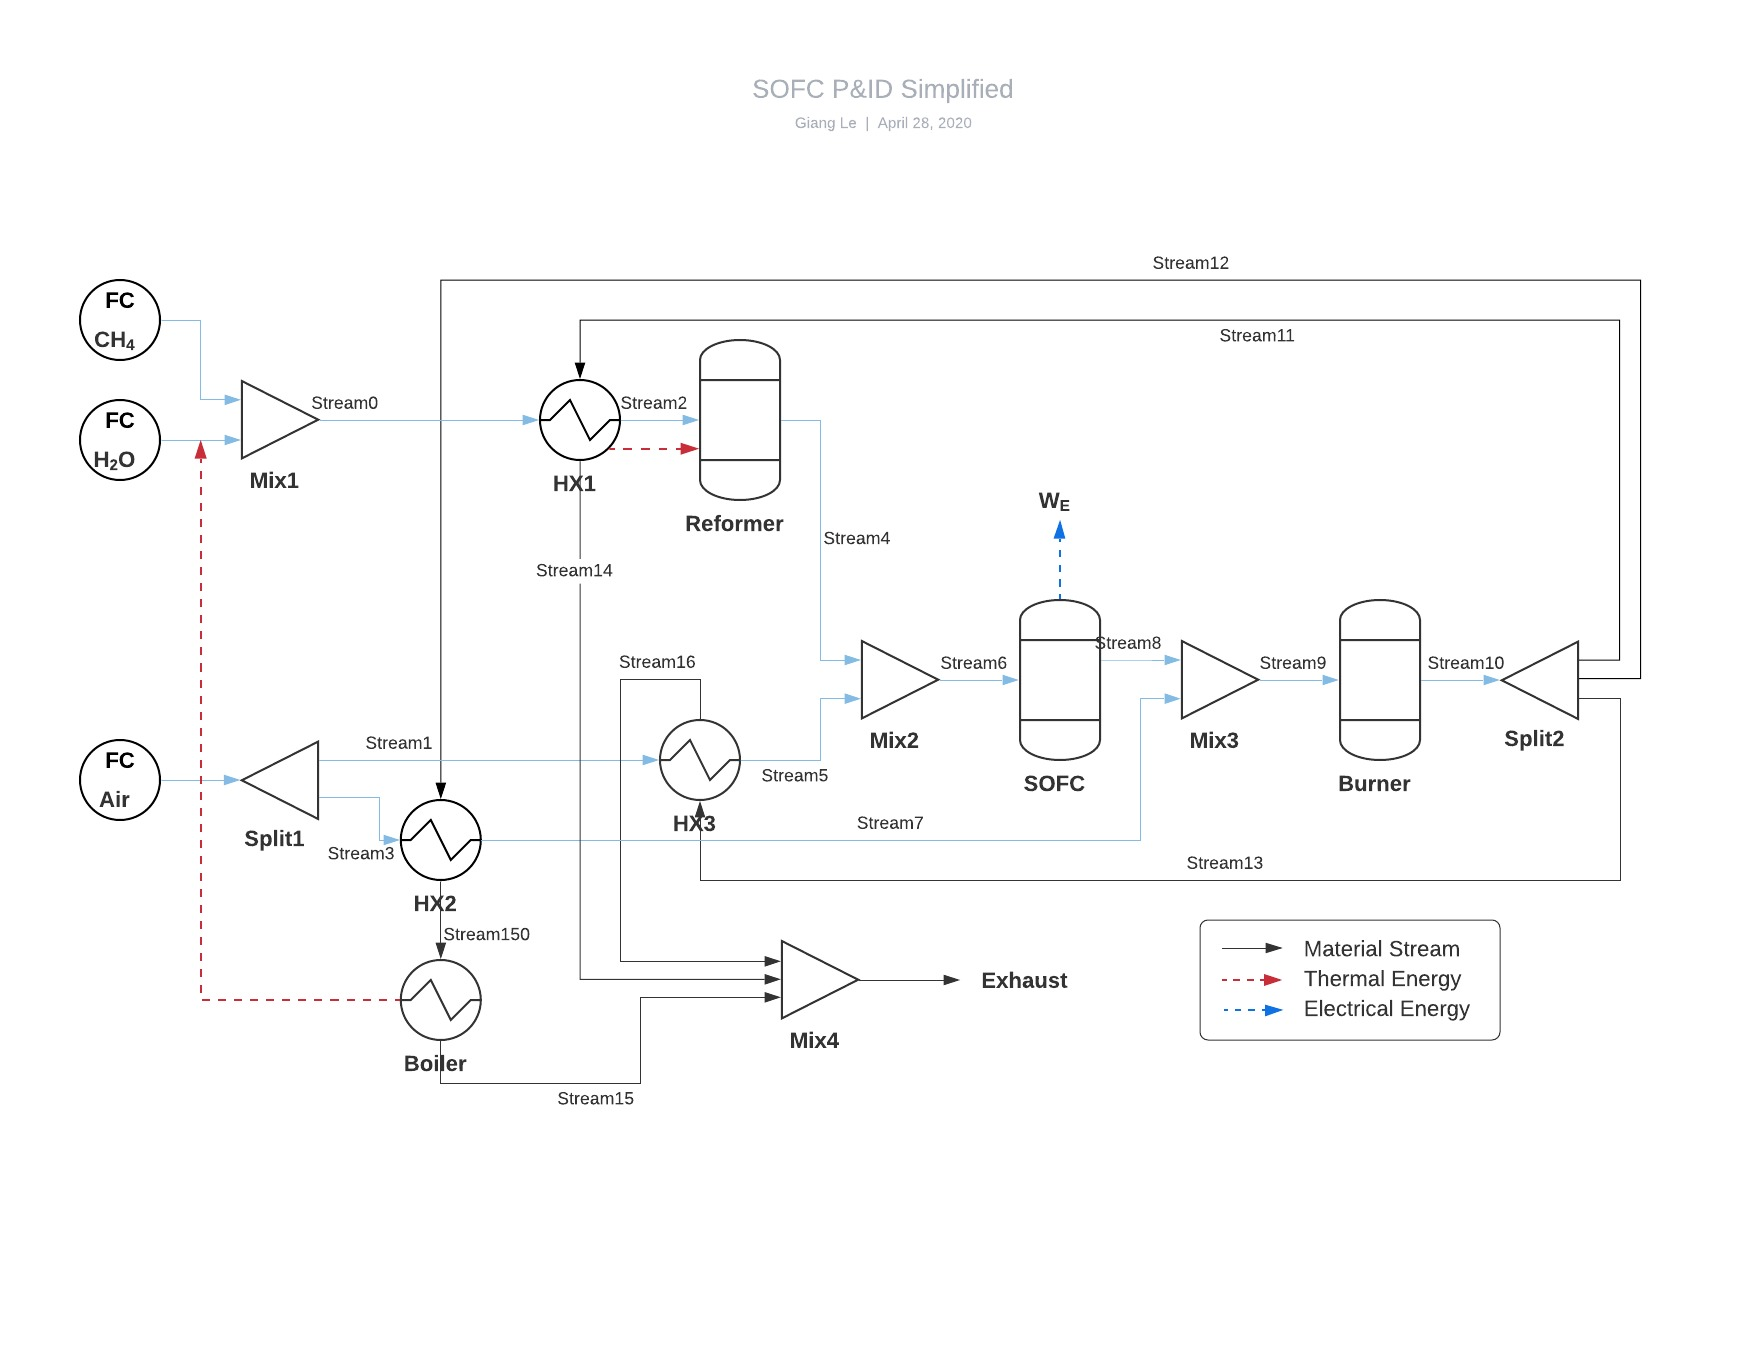

In [6]:
from IPython.display import Image
Image(filename='../../assets/images/SOFC-P&ID-Simplified.jpeg') 

### Declare all Units:

In [7]:
m.fs.HX1 = Heater(default={"property_package": m.fs.thermo_params})
m.fs.HX2a = Heater(default={"property_package": m.fs.thermo_params})
m.fs.HX2b = Heater(default={"property_package": m.fs.thermo_params})
m.fs.Mix1 = Mixer(default={"dynamic": False,
                           "property_package": m.fs.thermo_params})
m.fs.Mix2 = Mixer(default={"dynamic": False,
                           "property_package": m.fs.thermo_params})
m.fs.Mix3 = Mixer(default={"dynamic": False,
                           "property_package": m.fs.thermo_params})
m.fs.Split1 = Separator(default={"dynamic": False,
                                 "split_basis": SplittingType.componentFlow,
                                 "property_package": m.fs.thermo_params})
m.fs.Reformer = GibbsReactor(default={"dynamic": False,
                                      "property_package": m.fs.thermo_params,
                                      "has_pressure_change": False,
                                      "has_heat_transfer": True})
m.fs.SOFC = GibbsReactor(default={"dynamic": False,
                                  "property_package": m.fs.thermo_params,
                                  "has_pressure_change": False,
                                  "has_heat_transfer": True})
m.fs.Burner = GibbsReactor(default={"dynamic": False,
                                    "property_package": m.fs.thermo_params,
                                    "has_pressure_change": False,
                                    "has_heat_transfer": True})

### Declare all Streams:

In [8]:
m.fs.stream0 = Arc(source=m.fs.Mix1.outlet,
                   destination=m.fs.HX1.inlet)
m.fs.stream1 = Arc(source=m.fs.Split1.outlet_1,
                   destination=m.fs.HX2b.inlet)
m.fs.stream2 = Arc(source=m.fs.HX1.outlet,
                   destination=m.fs.Reformer.inlet)
m.fs.stream3 = Arc(source=m.fs.Split1.outlet_2,
                   destination=m.fs.HX2a.inlet)
m.fs.stream4 = Arc(source=m.fs.Reformer.outlet,
                   destination=m.fs.Mix2.inlet_1)
m.fs.stream5 = Arc(source=m.fs.HX2b.outlet,
                   destination=m.fs.Mix2.inlet_2)
m.fs.stream6 = Arc(source=m.fs.Mix2.outlet,
                   destination=m.fs.SOFC.inlet)
m.fs.stream7 = Arc(source=m.fs.HX2a.outlet,
                   destination=m.fs.Mix3.inlet_2)
m.fs.stream8 = Arc(source=m.fs.SOFC.outlet,
                   destination=m.fs.Mix3.inlet_1)
m.fs.stream9 = Arc(source=m.fs.Mix3.outlet,
                   destination=m.fs.Burner.inlet)

In [9]:
TransformationFactory("network.expand_arcs").apply_to(m)

### Define known Material Streams:

In [10]:
# Fix methane flow to Mix1:
m.fs.Mix1.inlet_1.flow_mol.fix(n_CH4f)
m.fs.Mix1.inlet_1.mole_frac_comp[0.0,:].fix(0.0)
m.fs.Mix1.inlet_1.mole_frac_comp[0.0,"CH4"].fix(1.0)
m.fs.Mix1.inlet_1.temperature.fix(25+273.15)
m.fs.Mix1.inlet_1.pressure.fix(101325)

In [11]:
# Fix water flow to Mix1:
m.fs.Mix1.inlet_2.flow_mol.fix(n_H2Of)
m.fs.Mix1.inlet_2.mole_frac_comp[0.0,:].fix(0.0)
m.fs.Mix1.inlet_2.mole_frac_comp[0.0,"H2O"].fix(1.0)
m.fs.Mix1.inlet_2.temperature.fix(25+273.15)
m.fs.Mix1.inlet_2.pressure.fix(101325)

In [12]:
# Fix air flow to Split1:
m.fs.Split1.inlet.flow_mol.fix(n_N2f+n_O2f)
m.fs.Split1.inlet.mole_frac_comp[0.0,:].fix(0.0)
m.fs.Split1.inlet.mole_frac_comp[0.0,"O2"].fix(0.21)
m.fs.Split1.inlet.mole_frac_comp[0.0,"N2"].fix(0.79)
m.fs.Split1.inlet.temperature.fix(25+273.15)
m.fs.Split1.inlet.pressure.fix(101325)

In [13]:
# Fix O2 flow in Split1 outlet_1:
m.fs.Split1.outlet_1.flow_mol.fix(n_CH4f*Uf*2)
m.fs.Split1.outlet_1.mole_frac_comp[0.0,"CH4"].fix(0.0)
m.fs.Split1.outlet_1.mole_frac_comp[0.0,"CO"].fix(0.0)
m.fs.Split1.outlet_1.mole_frac_comp[0.0,"CO2"].fix(0.0)
m.fs.Split1.outlet_1.mole_frac_comp[0.0,"H2"].fix(0.0)
m.fs.Split1.outlet_1.mole_frac_comp[0.0,"H2O"].fix(0.0)
m.fs.Split1.outlet_1.mole_frac_comp[0.0,"N2"].fix(0.0)
m.fs.Split1.outlet_1.mole_frac_comp[0.0,"O2"].fix(1.0)

### Constraints:  Adiabatic Burner

In [14]:
m.fs.Burner.heat_duty.fix(0.0)

### Constraints:  Adiabatic Reformer

In [15]:
m.fs.Reformer.heat_duty.fix(0.0)

### Constraints: Reformer temperature

In [16]:
m.fs.Reformer.outlet.temperature.fix(T_FC_fuel_in)

### Constraints: SOFC exit temperature

In [17]:
m.fs.SOFC.outlet.temperature.fix(T_FC_ex_out)

### Constraints: Air heat Exchanger tube-side outlet temperature

In [18]:
m.fs.HX2a.outlet.temperature.fix(T_FC_ex_out)

In [19]:
m.fs.HX2b.outlet.temperature.fix(T_FC_air_in)

In [20]:
dof(m)

0

### Initialize Blocks

In [37]:
m.fs.Mix1.initialize
m.fs.Mix2.initialize
m.fs.Mix3.initialize
m.fs.HX1.initialize
m.fs.HX2a.initialize
m.fs.HX2b.initialize
m.fs.Split1.initialize

<bound method SeparatorData.initialize of <idaes.core.process_block._ScalarSeparator object at 0x117ee6c18>>

### Solve:

In [44]:
solver = SolverFactory('glpk')

In [45]:
results = solver.solve(m, tee=True)

    solver 'glpk'


ApplicationError: No executable found for solver 'glpk'

In [46]:
# Solution:
print("Burner exhaust temperature: "+format(m.fs.Burner.outlet.temperature[0].value-273.15, ".2f")+ " oC")
print("SOFC energy output: "+format(-m.fs.SOFC.heat_duty[0].value*EE, ".2f")+ " J/s")
print("SOFC efficiency: "+format(-m.fs.SOFC.heat_duty[0].value*EE/(n_CH4f*LHV)*100, ".2f")+ " %")

Burner exhaust temperature: 25.00 oC
SOFC energy output: -0.00 J/s
SOFC efficiency: -0.00 %


In [47]:
# Temperature into Reformer:
print("Reformer entrance temperature: "+format(m.fs.Reformer.inlet.temperature[0].value-273.15, ".2f")+ " oC")

Reformer entrance temperature: 25.00 oC


## Heat Exchanger network

In [48]:
h = ConcreteModel()
h.fs = FlowsheetBlock(default={"dynamic": False})
h.fs.thermo_params = thermo_props.MethaneParameterBlock()

### All Unit Blocks

In [49]:
h.fs.Split2 = Separator(default={"dynamic": False,
                                 "num_outlets": 3,
                                 "property_package": h.fs.thermo_params})
h.fs.HX1a = HeatExchanger(default={"dynamic": False,
                                  "delta_temperature_callback": delta_temperature_amtd_callback,
                                  "shell":{"property_package": h.fs.thermo_params},
                                  "tube":{"property_package": h.fs.thermo_params}})
h.fs.HX2a = HeatExchanger(default={"dynamic": False,
                                  "delta_temperature_callback": delta_temperature_amtd_callback,
                                  "shell":{"property_package": h.fs.thermo_params},
                                  "tube":{"property_package": h.fs.thermo_params}})
h.fs.HX2b = HeatExchanger(default={"dynamic": False,
                                  "delta_temperature_callback": delta_temperature_amtd_callback,
                                  "shell":{"property_package": h.fs.thermo_params},
                                  "tube":{"property_package": h.fs.thermo_params}})
h.fs.HX1b = Heater(default={"property_package": h.fs.thermo_params})

### Streams:

In [50]:
h.fs.Split2.inlet.flow_mol.fix(m.fs.Burner.outlet.flow_mol[0].value)
h.fs.Split2.inlet.mole_frac_comp[0, "CH4"].fix(m.fs.Burner.outlet.mole_frac_comp[0, "CH4"].value)
h.fs.Split2.inlet.mole_frac_comp[0, "CO"].fix(m.fs.Burner.outlet.mole_frac_comp[0, "CO"].value)
h.fs.Split2.inlet.mole_frac_comp[0, "CO2"].fix(m.fs.Burner.outlet.mole_frac_comp[0, "CO2"].value)
h.fs.Split2.inlet.mole_frac_comp[0, "H2"].fix(m.fs.Burner.outlet.mole_frac_comp[0, "H2"].value)
h.fs.Split2.inlet.mole_frac_comp[0, "H2O"].fix(m.fs.Burner.outlet.mole_frac_comp[0, "H2O"].value)
h.fs.Split2.inlet.mole_frac_comp[0, "N2"].fix(m.fs.Burner.outlet.mole_frac_comp[0, "N2"].value)
h.fs.Split2.inlet.mole_frac_comp[0, "NH3"].fix(m.fs.Burner.outlet.mole_frac_comp[0, "NH3"].value)
h.fs.Split2.inlet.mole_frac_comp[0, "O2"].fix(m.fs.Burner.outlet.mole_frac_comp[0, "O2"].value)
h.fs.Split2.inlet.temperature.fix(m.fs.Burner.outlet.temperature[0].value)
h.fs.Split2.inlet.pressure.fix(m.fs.Burner.outlet.pressure[0].value)

In [51]:
h.fs.HX1a.tube_inlet.flow_mol.fix(m.fs.Mix1.outlet.flow_mol[0].value)
h.fs.HX1a.tube_inlet.mole_frac_comp[0, "CH4"].fix(m.fs.Mix1.outlet.mole_frac_comp[0, "CH4"].value)
h.fs.HX1a.tube_inlet.mole_frac_comp[0, "CO"].fix(m.fs.Mix1.outlet.mole_frac_comp[0, "CO"].value)
h.fs.HX1a.tube_inlet.mole_frac_comp[0, "CO2"].fix(m.fs.Mix1.outlet.mole_frac_comp[0, "CO2"].value)
h.fs.HX1a.tube_inlet.mole_frac_comp[0, "H2"].fix(m.fs.Mix1.outlet.mole_frac_comp[0, "H2"].value)
h.fs.HX1a.tube_inlet.mole_frac_comp[0, "H2O"].fix(m.fs.Mix1.outlet.mole_frac_comp[0, "H2O"].value)
h.fs.HX1a.tube_inlet.mole_frac_comp[0, "N2"].fix(m.fs.Mix1.outlet.mole_frac_comp[0, "N2"].value)
h.fs.HX1a.tube_inlet.mole_frac_comp[0, "NH3"].fix(m.fs.Mix1.outlet.mole_frac_comp[0, "NH3"].value)
h.fs.HX1a.tube_inlet.mole_frac_comp[0, "O2"].fix(m.fs.Mix1.outlet.mole_frac_comp[0, "O2"].value)
h.fs.HX1a.tube_inlet.temperature.fix(m.fs.Mix1.outlet.temperature[0].value)
h.fs.HX1a.tube_inlet.pressure.fix(m.fs.Mix1.outlet.pressure[0].value)

In [52]:
h.fs.HX2a.tube_inlet.flow_mol.fix(m.fs.Split1.outlet_1.flow_mol[0].value)
h.fs.HX2a.tube_inlet.mole_frac_comp[0, "CH4"].fix(m.fs.Split1.outlet_1.mole_frac_comp[0, "CH4"].value)
h.fs.HX2a.tube_inlet.mole_frac_comp[0, "CO"].fix(m.fs.Split1.outlet_1.mole_frac_comp[0, "CO"].value)
h.fs.HX2a.tube_inlet.mole_frac_comp[0, "CO2"].fix(m.fs.Split1.outlet_1.mole_frac_comp[0, "CO2"].value)
h.fs.HX2a.tube_inlet.mole_frac_comp[0, "H2"].fix(m.fs.Split1.outlet_1.mole_frac_comp[0, "H2"].value)
h.fs.HX2a.tube_inlet.mole_frac_comp[0, "H2O"].fix(m.fs.Split1.outlet_1.mole_frac_comp[0, "H2O"].value)
h.fs.HX2a.tube_inlet.mole_frac_comp[0, "N2"].fix(m.fs.Split1.outlet_1.mole_frac_comp[0, "N2"].value)
h.fs.HX2a.tube_inlet.mole_frac_comp[0, "NH3"].fix(m.fs.Split1.outlet_1.mole_frac_comp[0, "NH3"].value)
h.fs.HX2a.tube_inlet.mole_frac_comp[0, "O2"].fix(m.fs.Split1.outlet_1.mole_frac_comp[0, "O2"].value)
h.fs.HX2a.tube_inlet.temperature.fix(m.fs.Split1.outlet_1.temperature[0].value)
h.fs.HX2a.tube_inlet.pressure.fix(m.fs.Split1.outlet_1.pressure[0].value)

In [61]:
h.fs.HX2b.tube_inlet.flow_mol.fix(m.fs.Split1.outlet_2.flow_mol[0].value)
h.fs.HX2b.tube_inlet.mole_frac_comp[0, "CH4"].fix(m.fs.Split1.outlet_2.mole_frac_comp[0, "CH4"].value)
h.fs.HX2b.tube_inlet.mole_frac_comp[0, "CO"].fix(m.fs.Split1.outlet_2.mole_frac_comp[0, "CO"].value)
h.fs.HX2b.tube_inlet.mole_frac_comp[0, "CO2"].fix(m.fs.Split1.outlet_2.mole_frac_comp[0, "CO2"].value)
h.fs.HX2b.tube_inlet.mole_frac_comp[0, "H2"].fix(m.fs.Split1.outlet_2.mole_frac_comp[0, "H2"].value)
h.fs.HX2b.tube_inlet.mole_frac_comp[0, "H2O"].fix(m.fs.Split1.outlet_2.mole_frac_comp[0, "H2O"].value)
h.fs.HX2b.tube_inlet.mole_frac_comp[0, "N2"].fix(m.fs.Split1.outlet_2.mole_frac_comp[0, "N2"].value)
h.fs.HX2b.tube_inlet.mole_frac_comp[0, "NH3"].fix(m.fs.Split1.outlet_2.mole_frac_comp[0, "NH3"].value)
h.fs.HX2b.tube_inlet.mole_frac_comp[0, "O2"].fix(m.fs.Split1.outlet_2.mole_frac_comp[0, "O2"].value)
h.fs.HX2b.tube_inlet.temperature.fix(m.fs.Split1.outlet_2.temperature[0].value)
h.fs.HX2b.tube_inlet.pressure.fix(m.fs.Split1.outlet_2.pressure[0].value)

### Flows:

In [62]:
h.fs.stream0 = Arc(source=h.fs.Split2.outlet_1,
                   destination=h.fs.HX1a.shell_inlet)
h.fs.stream1 = Arc(source=h.fs.Split2.outlet_2,
                   destination=h.fs.HX2a.shell_inlet)
h.fs.stream2 = Arc(source=h.fs.Split2.outlet_3,
                   destination=h.fs.HX2b.shell_inlet)
h.fs.stream3 = Arc(source=h.fs.HX1a.shell_outlet,
                   destination=h.fs.HX1b.inlet)

    'pyomo.network.arc.SimpleArc'>) on block fs with a new Component
    (type=<class 'pyomo.network.arc.SimpleArc'>). This is usually indicative
    of a modelling error. To avoid this warning, use block.del_component() and
    block.add_component().
    'pyomo.network.arc.SimpleArc'>) on block fs with a new Component
    (type=<class 'pyomo.network.arc.SimpleArc'>). This is usually indicative
    of a modelling error. To avoid this warning, use block.del_component() and
    block.add_component().
    'pyomo.network.arc.SimpleArc'>) on block fs with a new Component
    (type=<class 'pyomo.network.arc.SimpleArc'>). This is usually indicative
    of a modelling error. To avoid this warning, use block.del_component() and
    block.add_component().
    'pyomo.network.arc.SimpleArc'>) on block fs with a new Component
    (type=<class 'pyomo.network.arc.SimpleArc'>). This is usually indicative
    of a modelling error. To avoid this warning, use block.del_component() and
    block.add_compo

In [63]:
TransformationFactory("network.expand_arcs").apply_to(h)

### Design constraints:

In [64]:
# heat transfer coeff of heat exchanger:
h.fs.HX1a.overall_heat_transfer_coefficient.fix(200)
h.fs.HX2a.overall_heat_transfer_coefficient.fix(200)
h.fs.HX2b.overall_heat_transfer_coefficient.fix(200)

In [65]:
# HX4/Evaporator:
h.fs.HX1b.heat_duty.fix(-n_H2Of*enthalpy_vap)

In [66]:
# HX cold/tube side outlet temperature:
h.fs.HX1a.tube_outlet.temperature.fix(m.fs.HX1.outlet.temperature[0].value)
h.fs.HX2a.tube_outlet.temperature.fix(T_FC_air_in)
h.fs.HX2b.tube_outlet.temperature.fix(T_FC_air_in)

In [67]:
# HX hot/shell side outlet temperature:
h.fs.HX2a.shell_outlet.temperature.fix(200+273.15)
h.fs.HX2b.shell_outlet.temperature.fix(200+273.15)

### DOF:

In [68]:
dof(h)

-44

### Solve:

In [69]:
solver = SolverFactory('ipopt')
results = solver.solve(h, tee=True)

    ipopt


ApplicationError: No executable found for solver 'ipopt'

### Solutions:

In [ ]:
print("HX1 - Steam, methane preheat heat exchanger: ")
print("\tTube inlet temperature: \t"+format(h.fs.HX1a.tube_inlet.temperature[0].value-273.15, ".2f")+" oC")
print("\tTube outlet temperature: \t"+format(h.fs.HX1a.tube_outlet.temperature[0].value-273.15, ".2f")+" oC")
print("\tShell inlet temperature: \t"+format(h.fs.HX1a.shell_inlet.temperature[0].value-273.15, ".2f")+" oC")
print("\tShell outlet temperature: \t"+format(h.fs.HX1b.outlet.temperature[0].value-273.15, ".2f")+" oC")

In [ ]:
print("HX2 - Air heat exchanger: ")
print("\tTube inlet temperature: \t"+format(h.fs.HX2a.tube_inlet.temperature[0].value-273.15, ".2f")+" oC")
print("\tTube outlet temperature: \t"+format(h.fs.HX2a.tube_outlet.temperature[0].value-273.15, ".2f")+" oC")
print("\tShell inlet temperature: \t"+format(h.fs.HX2a.shell_inlet.temperature[0].value-273.15, ".2f")+" oC")
print("\tShell outlet temperature: \t"+format(h.fs.HX2a.shell_outlet.temperature[0].value-273.15, ".2f")+" oC")
print("\tAssumed heat transfer coefficient: \t"+format(h.fs.HX2a.overall_heat_transfer_coefficient[0].value, ".2f")+ " W/m2.K")
print("\tHeat exchanger area: \t\t"+format(h.fs.HX2a.area.value+h.fs.HX2b.area.value, ".2f")+ " m2")

In [ ]:
print("Exhaust split ratio: ")
print("\tSplit fraction to methane, steam heat exchanger: "+format(h.fs.Split2.split_fraction[0, "outlet_1"].value, ".3f"))
print("\tSplit fraction to air heat exchanger: "+format(1-h.fs.Split2.split_fraction[0, "outlet_1"].value, ".3f"))